# Two Line Elements Propagation

# Set up 

In [1]:
%matplotlib inline

## Initialize Orekit 

In [2]:
import orekit
vm = orekit.initVM()

Read the orekit-data file with basic paramters. This file is assumed to be in the current directory.

In [3]:
from orekit.pyhelpers import setup_orekit_curdir
setup_orekit_curdir()

Now we are set up to import and use objects from the orekit library.

In [4]:
from org.orekit.frames import FramesFactory, TopocentricFrame
from org.orekit.bodies import OneAxisEllipsoid, GeodeticPoint
from org.orekit.time import TimeScalesFactory, AbsoluteDate, DateComponents, TimeComponents
from org.orekit.utils import IERSConventions, Constants

from org.orekit.propagation.analytical.tle import TLE, TLEPropagator

In [5]:
from math import radians, pi
import matplotlib.pyplot as plt

## Setting up the TLE 

Specify the two line elements that describes the orbit of the satellite as strings. Here these are specified directly, in a larger example these would likely be fetched from a file or from an on-line service.

In [6]:
#SPOT-5 gonna add new TLEs
tle_line1 = "1 44238U 19029D   21157.84096044  .00001730  00000-0  10521-3 0  9996"
tle_line2 = "2 44238  52.9972  36.6900 0001538  92.9149 267.2020 15.15892150111090"

The orekit TLE object parses the two line strings. [See TLE Doc](https://www.orekit.org/static/apidocs/org/orekit/propagation/analytical/tle/TLE.html) The Epoch is the timestamp where the two line elements are referenced to.

In [7]:
mytle = TLE(tle_line1,tle_line2)

print (mytle)
print ('Epoch :',mytle.getDate())

1 44238U 19029D   21157.84096044  .00001730  00000-0  10521-3 0  9996
2 44238  52.9972  36.6900 0001538  92.9149 267.2020 15.15892150111090
Epoch : 2021-06-06T20:10:58.982


## Preparing the Coordinate systems 

Orekit supports several coordinate systems, for this example the International Terrestrial Reference Frame (ITRF) is used for the planet. A slightly elliptical body is created for the Earth shape, according to the WGS84 model.

In [8]:
ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)

## Define the station

The location of the station is defined, and a [TopocentricFrame](https://www.orekit.org/site-orekit-10.1/apidocs/org/orekit/frames/TopocentricFrame.html) specific for this location is created.

This frame is based on a position near the surface of a body shape. The origin of the frame is at the defining geodetic point location, and the right-handed canonical trihedra is:

- X axis in the local horizontal plane (normal to zenith direction) and following the local parallel towards East
- Y axis in the horizontal plane (normal to zenith direction) and following the local meridian towards North
- Z axis towards Zenith direction

In [9]:
longitude = radians(21.063)
latitude  = radians(67.878)
altitude  = 341.0
station = GeodeticPoint(latitude, longitude, altitude)
station_frame = TopocentricFrame(earth, station, "Esrange")

For the propagation a Earth centered inertial coordinate system is used, the EME2000. This frame is commonly also called J2000. This is a commonly used frame centered at the Earth, and fixed towards reference stars (not rotating with the Earth).

In [10]:
inertialFrame = FramesFactory.getEME2000()

In [20]:
propagator = TLEPropagator.selectExtrapolator(mytle)

Set the start and end date that is then used for the propagation.

In [24]:
extrapDate = AbsoluteDate(2002, 5, 7, 12, 0, 0.0, TimeScalesFactory.getUTC())
finalDate = extrapDate.shiftedBy(60.0*60*24) #seconds

In [25]:
el=[]
pos=[]

This is the core loop that performs the propagation, stepping extrapDate through the range with set stepsize. The results are stored in the el and pos lists.

In [26]:
while (extrapDate.compareTo(finalDate) <= 0.0):  
    pv = propagator.getPVCoordinates(extrapDate, inertialFrame)
    pos_tmp = pv.getPosition()
    pos.append((pos_tmp.getX(),pos_tmp.getY(),pos_tmp.getZ()))
    
    el_tmp = station_frame.getElevation(pv.getPosition(),
                    inertialFrame,
                    extrapDate)*180.0/pi
    el.append(el_tmp)
    print (extrapDate, pos_tmp)
    extrapDate = extrapDate.shiftedBy(10.0)
    

02-05-08T11:23:10.000 {4,774,276.981122159; 3,042,397.2551141074; -4,047,694.1215676893}
2002-05-08T11:23:20.000 {4,718,944.543303077; 3,073,519.867280721; -4,088,863.3632160337}
2002-05-08T11:23:30.000 {4,663,054.505690895; 3,104,279.295789959; -4,129,548.141179981}
2002-05-08T11:23:40.000 {4,606,613.496485465; 3,134,671.924905266; -4,169,743.6601801603}
2002-05-08T11:23:50.000 {4,549,628.214208958; 3,164,694.179208831; -4,209,445.178909872}
2002-05-08T11:24:00.000 {4,492,105.415450106; 3,194,342.530194442; -4,248,648.018750771}
2002-05-08T11:24:10.000 {4,434,051.920032433; 3,223,613.493373578; -4,287,347.559955192}
2002-05-08T11:24:20.000 {4,375,474.613367593; 3,252,503.6271606055; -4,325,539.240169091}
2002-05-08T11:24:30.000 {4,316,380.437553036; 3,281,009.537315558; -4,363,218.560313329}
2002-05-08T11:24:40.000 {4,256,776.396745792; 3,309,127.8742008256; -4,400,381.080956799}
2002-05-08T11:24:50.000 {4,196,669.556409738; 3,336,855.333219037; -4,437,022.422901418}
2002-05-08T11:25:

## Plot Results

Plot some of the results from the propagation. Note that in the plots below the x-axis are samples and not proper time.

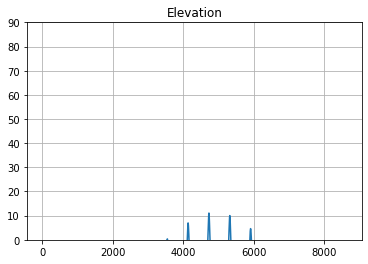

In [15]:
plt.plot(el)
plt.ylim(0,90)
plt.title('Elevation')
plt.grid(True)

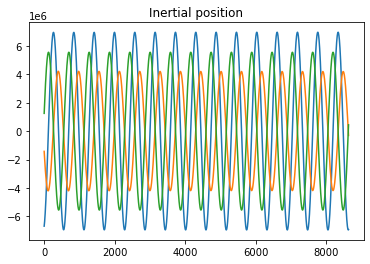

In [16]:
plt.plot(pos); 
plt.title('Inertial position');

## Exercise

Evaluate the maximum elevation of the International Space Station from your current location and for the coming 5 days, and at what time and date it occurs. The Two-Line Elements needs to be fresh, and fetched from internet. One site that is publishing recent elements is [Celestrack](https://www.celestrak.com/NORAD/elements/). Verify that the used TLE is fresh using the epoch.